<a href="https://colab.research.google.com/github/moni6264/deeplearning2/blob/main/DL_ASS_2_PART(B)_inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 4.7 MB/s 
     |████████████████████████████████| 181 kB 61.6 MB/s 
     |████████████████████████████████| 144 kB 55.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=2e91637f61abd0c0d3c220bbcfc948ffb1c0babd3b1af913b74ba2834388f329
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
import os
import glob
import wandb
import numpy as np 
import random
from wandb.keras import WandbCallback
import tensorflow as tf
from keras.layers import Conv2D , MaxPool2D , Flatten , Dropout, Dense, Activation, BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential, load_model
import random
import wandb
import shutil
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from wandb.keras import WandbCallback 


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import tensorflow.keras as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop



In [3]:
try:
    shutil.rmtree("inaturalist_12K") # helps you automate copying files and directories
except:
    pass

try:
    os.remove("nature_12K.zip")
except:
    pass

In [4]:
%%capture
!unzip "/content/drive/MyDrive/nature_12K.zip"   # location of natural set data

In [5]:
!find . -name "*.DS_Store" -type f -delete #capture the path where your file is currently stored


load a dataset

In [6]:
temp = os.listdir("inaturalist_12K/train")
class_names = [name for name in temp if name != ".DS_Store"] # print class_name (each folder)
print("The names of the classes are:")
print(class_names)

num_classes = len(class_names)
print(f"Number of classes = {num_classes}\n")

M = 0     
M_test = 0

for each_class in class_names:
    train_images = os.listdir("inaturalist_12K/train/"+each_class) # trainset
    test_images = os.listdir("inaturalist_12K/val/"+each_class) # test set
    filtered_train_images = list(filter(lambda x: x!=".DS_Store", train_images)) 
    filtered_test_images = list(filter(lambda x: x!=".DS_Store", test_images))
    M = M + len(filtered_train_images)
    M_test = M_test + len(filtered_test_images)

print(f"Total number of training images = {M}") 
print(f"Total number of test images = {M_test}\n")


The names of the classes are:
['Insecta', 'Amphibia', 'Mammalia', 'Aves', 'Reptilia', 'Arachnida', 'Animalia', 'Plantae', 'Mollusca', 'Fungi']
Number of classes = 10

Total number of training images = 9999
Total number of test images = 2000



spliting validation data

In [7]:
validation_split_fraction = 0.1 # spliting the validation data 

try:
    shutil.rmtree("inaturalist_12K/validation/")  #automate copying files and directories
except:
    pass
    
os.mkdir("inaturalist_12K/validation/") # create the validation path 

for each_class in class_names:
    os.mkdir("inaturalist_12K/validation/"+each_class)
    train_images = os.listdir("inaturalist_12K/train/"+each_class)
    filtered_train_images = list(filter(lambda x: x!=".DS_Store", train_images))
    count = len(filtered_train_images)
    random.shuffle(filtered_train_images) # Shuffle the training images

    validation_images = filtered_train_images[:round(validation_split_fraction*count)]

    for im in validation_images:
        shutil.move("inaturalist_12K/train/"+each_class+"/"+im, "inaturalist_12K/validation/"+each_class+"/"+im) # final create validation imges

Check the input image

In [8]:
input_image_shape = (224, 224, 3)


Spilting data test (train test validation)

In [9]:
def create_generators(train_batch_size, data_aug):

    if data_aug:
        train_data_gen = ImageDataGenerator(rescale=1./255,height_shift_range=0.2, width_shift_range=0.2,
                                        horizontal_flip=True,
                                        zoom_range=0.2,
                                        fill_mode="nearest")
                                       
    else:
        train_data_gen = ImageDataGenerator(rescale=1./255)

    validation_data_gen = ImageDataGenerator(rescale=1./255)

    test_data_gen = ImageDataGenerator(rescale=1./255)

    train_generator = train_data_gen.flow_from_directory(
        'inaturalist_12K/train',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=train_batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42) # random seed is a starting point in generating random numbers

    # batch_size for validation and test generator
    validation_generator = validation_data_gen.flow_from_directory(
        'inaturalist_12K/validation',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=100,
        class_mode='categorical',
        shuffle=True,
        seed=42)

    test_generator = test_data_gen.flow_from_directory(
        'inaturalist_12K/val',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=100,
        class_mode='categorical',
        shuffle=False,
        seed=42)
    
    return train_generator, validation_generator, test_generator

Build model in image net 

In [10]:
def define_model(pretrained_model_name, activation_function_dense, fc_layer, dropout, pre_layer_train=None):
  # keras sequential model based on a pre-trained model intended to be fine tuned and fc fulled connected 
    

    input_ = K.Input(shape = input_image_shape)

    # add a pretrained model without the top dense layer
    if pretrained_model_name == 'ResNet50':
      pretrained_model = K.applications.ResNet50(include_top = False, weights='imagenet',input_tensor = input_)
    elif pretrained_model_name == 'InceptionV3':
      pretrained_model = K.applications.InceptionV3(include_top = False, weights='imagenet',input_tensor = input_)
    elif pretrained_model_name == 'InceptionResNetV2':
      pretrained_model = K.applications.InceptionResNetV2(include_top = False, weights='imagenet',input_tensor = input_)
    else:
      pretrained_model = K.applications.Xception(include_top = False, weights='imagenet',input_tensor = input_)
    
    #freeze all layers
    for layer in pretrained_model.layers:
        layer.trainable=False 
    
    #set some of the top layers as trainable
    if pre_layer_train:
      for layer in pretrained_model.layers[-pre_layer_train:]:
        layer.trainable=True

    model = K.models.Sequential()
    model.add(pretrained_model)#add pretrained model
    model.add(Flatten()) # The flatten layer is essential to convert the activation  map into a column vector
    model.add(Dense(fc_layer, activation=activation_function_dense))#add a dense layer
    model.add(Dropout(dropout)) # For dropout
    model.add(Dense(10, activation="softmax"))#softmax layer

    return model

Training validation model 

In [11]:
def train_validate_model(train_batch_size, pre_train_model, data_aug, activation_function_dense, fc_layer, dropout, pre_layer_train=None):
# train the model based on the given hyperparameters and plot train validatiob accuracy with each epochs 
  # Create the data generators
  train_generator, validation_generator, test_generator = create_generators(train_batch_size, data_aug)
    
  # Define the model
  model = define_model(pretrained_model_name=pre_train_model, activation_function_dense=activation_function_dense, fc_layer=fc_layer, dropout=dropout, pre_layer_train=pre_layer_train)
  print(model.summary()) # create model 

  TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size # declare step size for train data
  VALIDATION_STEP_SIZE = validation_generator.n//validation_generator.batch_size # declare step size for validation data

  #compile
  model.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy']) # compiler with optimizer and loss

  # Early Stopping callback
  earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min') # regularization technique
# save the best model 
  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

  history = model.fit(train_generator,
                      steps_per_epoch = TRAIN_STEP_SIZE,
                      validation_data = validation_generator,
                      validation_steps = VALIDATION_STEP_SIZE,
                      epochs=5, 
                      callbacks=[earlyStopping, mc],
                      verbose=2)
    # plot for accuracy vs validation accuracy 

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()
    # plot for loss vs validation loss 

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  return history

Image net with hyper parameter 

In [12]:
pre_train_model = "InceptionV3"#change here to change model for wandb sweeps InceptionV3, InceptionResNetV2, ResNet50, Xception
activation_function_dense = "relu"#set as constant 

create with sweeps and trained model 

In [14]:
def train_validate_model():
    config_defaults = {
        "data_aug": True,
        "train_batch_size": 128,
        "dropout": 0,
        "fc_layer": 256,
        "pre_layer_train": None,
        "epochs": 5
    }

    # Initialize a new wandb ru
    wandb.init(config=config_defaults)
    
    # Config is a variable that have sweeps 
    config = wandb.config

    # Local variables
    data_aug = config.data_aug
    train_batch_size = config.train_batch_size
    dropout = config.dropout
    fc_layer = config.fc_layer
    pre_layer_train = config.pre_layer_train
    epochs = config.epochs
    
    # Display the hyperparameters 
    run_name = "model_{}_aug_{}_bs_{}_drop_{}_fc_{}_fre_{}_epoc_{}".format(pre_train_model, data_aug, train_batch_size, dropout, fc_layer, pre_layer_train, epochs )
    print(run_name)

    # Create the generator 
    train_generator, validation_generator, test_generator = create_generators(train_batch_size, data_aug)
    
    # Define the model
    model = define_model(pretrained_model_name=pre_train_model, activation_function_dense=activation_function_dense, fc_layer=fc_layer, dropout=dropout, pre_layer_train=pre_layer_train)
    print(model.count_params())

    #declare step size both training and validation 

    TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size
    VALIDATION_STEP_SIZE = validation_generator.n//validation_generator.batch_size

    #compile with optimizer and loss function 

    model.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    # Early Stopping callback
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

    # To save the model with best validation accuracy
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

    history = model.fit(train_generator,
                        steps_per_epoch = TRAIN_STEP_SIZE,
                        validation_data = validation_generator,
                        validation_steps = VALIDATION_STEP_SIZE,
                        epochs=epochs, 
                        callbacks=[WandbCallback(data_type="image", generator=validation_generator), earlyStopping, mc],
                        verbose=2)
    # plot for accuracy vs validation accuracy 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # plot for loss vs validation loss 
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()
    return history

Running sweeps configuration 

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 7bfqwfsn
Sweep URL: https://wandb.ai/moni6264/test_InceptionV3/sweeps/7bfqwfsn


wandb: Agent Starting Run: 1uk5kl7v with config:
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	fc_layer: 256
wandb: 	pre_layer_train: 10
wandb: 	train_batch_size: 128
wandb: Currently logged in as: moni6264 (use `wandb login --relogin` to force relogin)


model_InceptionV3_aug_True_bs_128_drop_0.2_fc_256_fre_10_epoc_5
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
87924736/87910968 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
wandb: WARNING The data_type argument of wandb.keras.WandbCallback is deprecated and will be removed in a future release. Please use input_type instead.
wandb: WARNING Setting input_type = data_type.


34912810
Epoch 1/5
70/70 - 269s - loss: 1.8041 - accuracy: 0.4969 - val_loss: 0.9655 - val_accuracy: 0.6830 - _timestamp: 1648045443.0000 - _runtime: 282.0000 - 269s/epoch - 4s/step
Epoch 2/5
70/70 - 236s - loss: 1.0893 - accuracy: 0.6548 - val_loss: 0.9618 - val_accuracy: 0.7100 - _timestamp: 1648045737.0000 - _runtime: 576.0000 - 236s/epoch - 3s/step
Epoch 3/5
70/70 - 226s - loss: 1.0142 - accuracy: 0.6705 - val_loss: 0.8426 - val_accuracy: 0.7280 - _timestamp: 1648045963.0000 - _runtime: 802.0000 - 226s/epoch - 3s/step
Epoch 4/5
70/70 - 234s - loss: 0.9629 - accuracy: 0.6875 - val_loss: 0.8238 - val_accuracy: 0.7330 - _timestamp: 1648046232.0000 - _runtime: 1071.0000 - 234s/epoch - 3s/step
Epoch 5/5
70/70 - 221s - loss: 0.9513 - accuracy: 0.6911 - val_loss: 0.8341 - val_accuracy: 0.7200 - _timestamp: 1648046484.0000 - _runtime: 1323.0000 - 221s/epoch - 3s/step


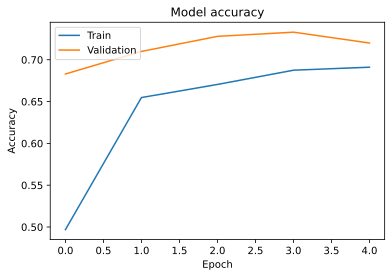

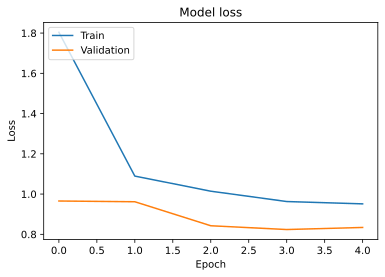

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_accuracy,▁▅▇█▆
val_loss,██▂▁▂
accuracy,0.69113
best_epoch,3
best_val_loss,0.82377
epoch,4
loss,0.95132
val_accuracy,0.72


In [15]:
sweep_config = {
  "name": "Test part B ",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "bayes",
  "parameters": {
        "data_aug": {
            "values": [True, False]
        },
        "train_batch_size": {
            "values": [64, 128]
        },
        "dropout": {
            "values": [0, 0.2, 0.1]
        },
        "fc_layer": {
            "values": [128, 256, 512]
        },
        "pre_layer_train": {
            "values": [None, 10, 20]
        },
        "epochs":{
            "values": [5]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="moni6264", project="test_InceptionV3")
wandb.agent(sweep_id, train_validate_model, count=1)